# Sec Recon Analyses

Here we perform different analyses to test the quality of secRecon

In [17]:
import datetime
import pickle
import tqdm.notebook as tqdm
import networkx as nx

import re
import pandas as pd
import numpy as np
from Bio import Entrez
import Request_Utilis
from google_sheet import GoogleSheet
from collections import defaultdict

# Plotting libraries
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
from venn import venn
from upsetplot import UpSet
import matplotlib.pyplot as plt
from itertools import product

# Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1L6qQQs48OdFd-mJcVqov_rSDoV90Ta0kib6UpL81OJQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_genes_sheet = 'SecRecon'
ontology_sheet = 'Ontology'

sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)
ontology = sec_recon_gsheet_file.read_google_sheet(ontology_sheet)

### Network Analysis

In this section we'll use the networks generated in the Network_visualization notebook to visualize experimental data from a CHO High vs Low dataset

In [3]:
# Read dataset
cho_vs_plasma_prot = pd.read_excel('Data/cho_vs_plasma/1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'Proteome DE proteins')

cho_vs_plasma_rna = pd.read_excel('Data/cho_vs_plasma/1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'Transcriptome DE')

In [4]:
# Read gene_dict from the pickle file

with open('gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

In [5]:
# Map Mouse genes to Human genes

dict_mouse_human = dict(zip(sec_genes['MOUSE GENE SYMBOL'], sec_genes['GENE SYMBOL']))
cho_vs_plasma_prot['Human_Genes'] = cho_vs_plasma_prot['Mmus_Genes'].map(dict_mouse_human)

In [6]:
# Filter rows where 'Human_Genes' is not NaN
filtered_df = cho_vs_plasma_prot[cho_vs_plasma_prot['Human_Genes'].notna()]

In [7]:
filtered_df

,Mmus_Protein_Accession,Hsap_Protein_Accession,Mmus_Genes,Mmus_UniProt,FC PCD/CHO,log2_MPC-11_Rep1_intensity_sum,log2_MPC-11_Rep2_intensity_sum,log2_MPC-11_Rep3_intensity_sum,log2_P3X_Rep1_intensity_sum,log2_P3X_Rep2_intensity_sum,...,log2 CHO-DG44-mAb1_Rep2_intensity_sum,log2 CHO-DG44-mAb1_Rep3_intensity_sum,log2 CHO-K1-mAb2_Rep1_intensity_sum,log2 CHO-K1-mAb2_Rep2_intensity_sum,log2 CHO-K1-mAb2_Rep3_intensity_sum,-Log Student's T-test p-value CHO_PCD,Student's T-test q-value CHO_PCD,Student's T-test Difference CHO_PCD,Student's T-test Test statistic CHO_PCD,Human_Genes
0,NP_001271241 : NP_001271243,NP_477515,Ube2j2,Q6P073;Q8C6A1;Q91Y64;Q9CWY5;Q9DC18;Q9QX58,0.140150,13.629981,16.206366,15.531327,16.234344,15.525386,...,19.078819,19.692989,16.942184,18.609709,15.935396,2.573714,0.012773,2.834959,1.652887,UBE2J2
6,NP_033524,NP_004772,Vamp3,P63024;Q3TH70;Q64271,25.537974,22.478949,20.973793,21.328415,20.219084,19.987700,...,15.788644,15.188700,16.895157,16.474741,15.227417,5.003014,0.000132,-4.674572,-2.971577,VAMP3
8,XP_006539151 : NP_071305,NP_001099032 : NP_006039,Ube4b,Q6DID4;Q9EQE0;Q9ES00,18.907662,17.857023,22.699270,21.888166,22.003618,21.506588,...,16.543081,17.243269,16.953245,17.490749,16.045765,3.674656,0.001595,-4.240899,-2.423126,UBE4B
11,NP_035252,NP_000293,Plod1,Q9R0E2,0.022764,17.614872,17.758505,17.191219,16.833832,15.550310,...,21.745548,21.815578,22.983053,23.013390,21.343483,5.903990,0.000025,5.457129,3.563255,PLOD1
15,NP_001017966,NP_115717,Ddi2,A2ADY9,15.787030,18.073822,21.255577,20.580421,21.971743,21.689604,...,17.370712,16.968752,16.332691,17.664955,14.597779,3.520264,0.002110,-3.980668,-2.291314,DDI2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1470,XP_006502046,NaN,Dpm3,Q9D1Q4,3.324610,18.239634,17.946306,18.339043,19.081547,18.351440,...,17.463209,16.422903,18.353960,16.249781,15.440761,2.135373,0.028969,-1.733185,-1.142638,DPM3
1479,NP_598648,NaN,Stx12,Q3UIV9;Q921T9;Q9ER00,0.148055,21.865564,19.649406,20.144907,19.087095,19.602390,...,22.675575,23.021692,22.360167,22.619707,22.378098,3.897221,0.001032,2.755796,1.891537,STX12
1504,XP_017168054,NaN,Fkbp8,O35465;Q3UK86;Q6GTX9;Q811M7;Q811R4;Q8C2F0;Q99L93,0.297001,21.207478,21.162157,20.900770,20.227121,19.857685,...,22.884487,23.052029,22.399035,22.225080,20.900406,2.723500,0.009532,1.751462,1.234213,FKBP8
1526,NP_033523,NaN,Vamp2,P63044;Q64357,4.936048,18.913500,16.660015,16.665630,20.219084,19.987700,...,15.602940,15.796114,16.692833,17.393965,15.479699,2.055763,0.033236,-2.303356,-1.347132,VAMP2


In [8]:
for i,row in filtered_df.iterrows():
    g = row['Human_Genes']
    if g in gene_dict.keys():
        gene_dict[g]['Expression'] = float(row['FC PCD/CHO'])

In [12]:
G = nx.read_graphml('Network/sec_recon_network.graphml')

# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G.nodes(data=True)}

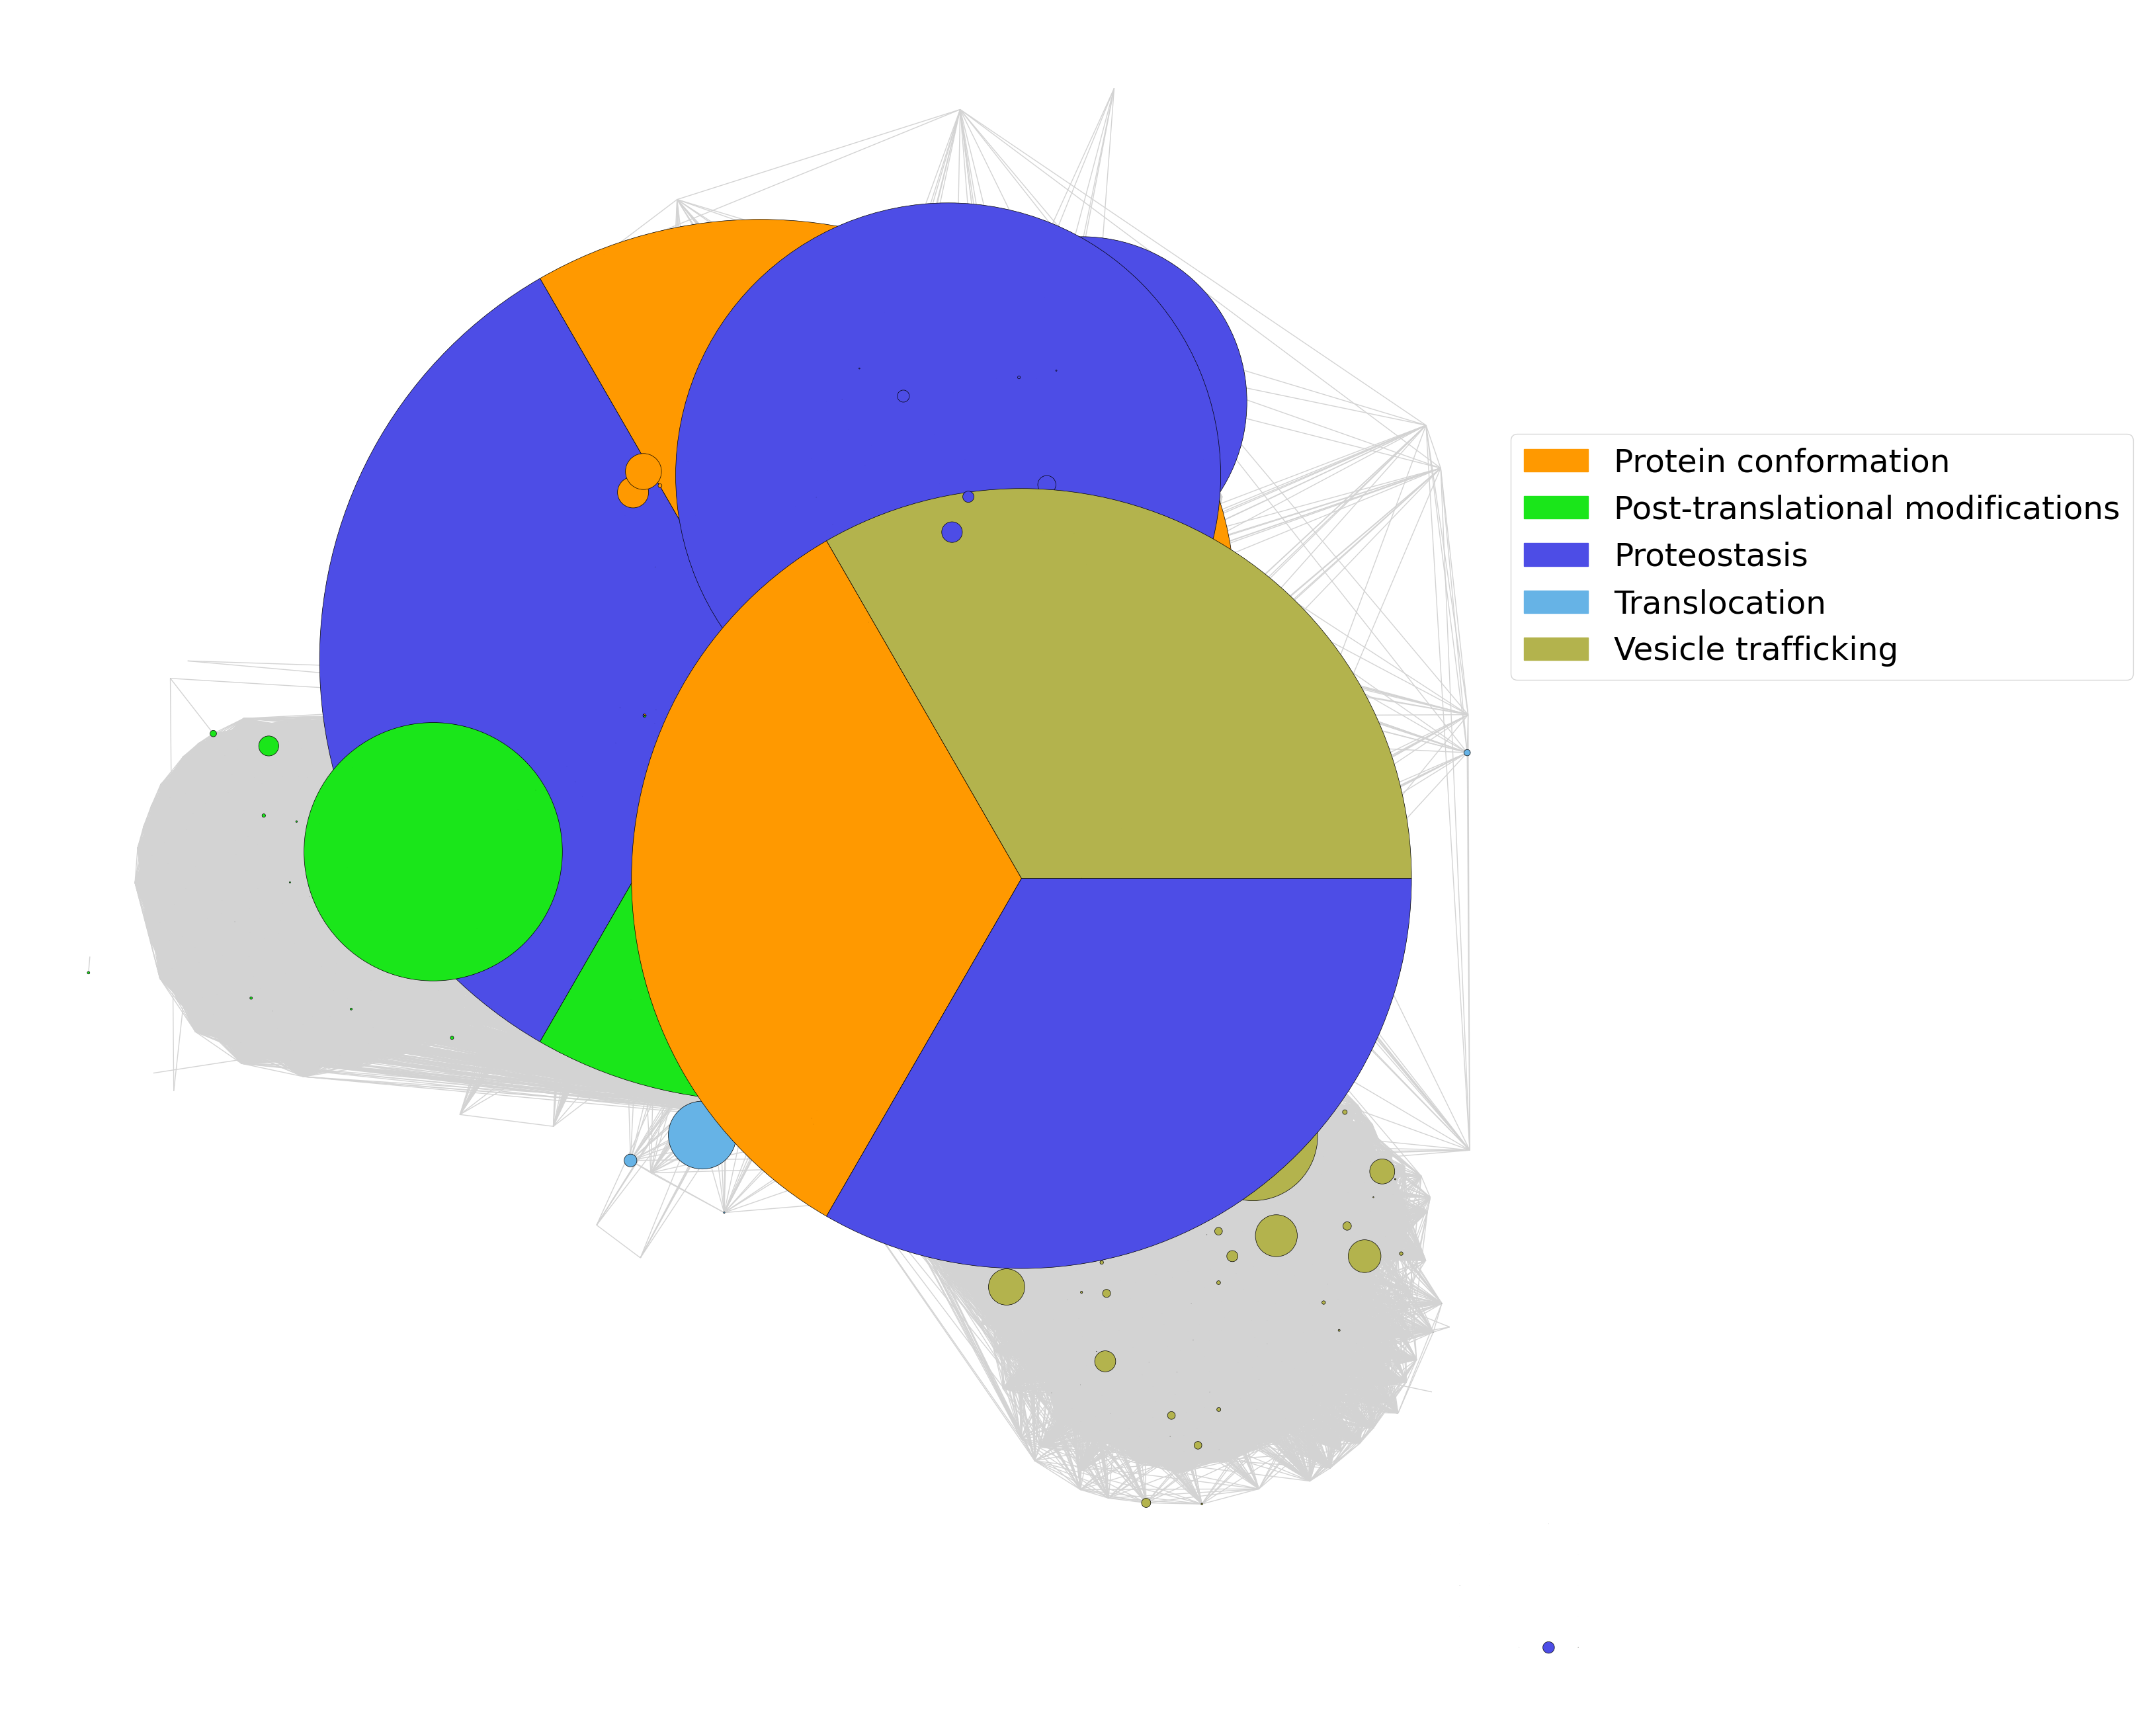

In [19]:
system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0)
}

radius_coeff = 0.000265
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])

    
# Draw nodes as pie charts
for node, (x, y) in pos.items():
    systems = gene_dict[node]['systems']
    
    # Adjust the alpha value of each color
    colors = [system_colors[sys] for sys in systems]
    
    # Draw pie chart at node position with edgecolor and linewidth
    #ax.pie([1]*len(systems), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    try:
        radius = gene_dict[node]['Expression'] * radius_coeff + 0.0000001
    except:
        radius = 0.0000001
    ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))

# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
plt.subplots_adjust(right=0.75)

plt.savefig('Network/secrecon_network_systems.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 2. Identification of secRecon genes in CRISPR CHO whole genome library

In [ ]:
# Load CRISPR library dataset
guide_rna = pd.read_excel('Data/guide_rna_lib/CRISPR_a_Library_sorted_file_without_duplicates.xlsx')

# Load guide RNA with NT dataset
guide_rna_ntg = pd.read_excel('Data/guide_rna_lib/CRISPRa_library_manifest_NTG_without_duplicates.xlsx')

# Load TFs from IPA dataset
ipa_tfs = pd.read_excel('Data/IPA_analysis/TF_secrecon_lists.xlsx', sheet_name = 'IPA_results_85-TF', usecols='B')

In [ ]:
# Find common genes between CRISPR library and secRecon
guide_rna['gene_lower'] = guide_rna['target_name'].str.replace('gene-', '')
common_genes_sec_recon = guide_rna[guide_rna['gene_lower'].isin(sec_genes['CHO GENE SYMBOL'])]
common_genes_sec_recon = common_genes_sec_recon.drop(['gene_lower'], axis=1)

In [ ]:
guide_rna.sample(10)

In [ ]:
# Find common genes between CRISPR library and IPA Analysis
guide_rna['gene_upper'] = guide_rna['target_name'].str.replace('gene-', '').str.upper()
common_genes_ipa = guide_rna[guide_rna['gene_upper'].isin(ipa_tfs['Upstream Regulator'])]
common_genes_ipa = common_genes_ipa.drop(['gene_upper','gene_lower'], axis=1)

In [ ]:
# Combine datasets
final_df = pd.concat([common_genes_sec_recon, common_genes_ipa], ignore_index=True)

In [ ]:
# Filter NT dataset

# Filter rows where 'Name' is in 'Manifest Name' of final_df
filter_condition = guide_rna_ntg['Name'].isin(final_df['Manifest Name'])

# Filter rows where 'Name' starts with 'NT_'
nt_condition = guide_rna_ntg['Name'].str.startswith('NT_')

# Combine both conditions
combined_condition = filter_condition | nt_condition

# Apply the combined filter
filtered_guide_rna_ntg = guide_rna_ntg[combined_condition]

In [ ]:
filtered_guide_rna_ntg

In [ ]:
# Comparison of genes in the CRISPR library and secRecon

print(f' Total genes in CRISPR library: {len(guide_rna.target_name.unique())}')
print(f' Genes in CRISPR library covered by secRecon: {len(common_genes_sec_recon.target_name.unique())}')
print(f' Total CHO genes in secRecon:',len(sec_genes['CHO GENE SYMBOL'].unique()))

In [ ]:
# Comparison of genes in the CRISPR library and IPA analysis

print(f' Total genes in CRISPR library: {len(guide_rna.target_name.unique())}')
print(f' Genes in CRISPR library covered by IPA analysis: {len(common_genes_ipa.target_name.unique())}')
print(f' Total CHO genes in IPA TFs:',len(ipa_tfs['Upstream Regulator'].unique()))

In [ ]:
common_genes_sec_recon.to_excel('Data/guide_rna_lib/CRISPR_a_Library_sorted_file_without_duplicates_sec_genes.xlsx', index=False)
common_genes_ipa.to_excel('Data/guide_rna_lib/CRISPR_a_Library_sorted_file_without_duplicates_ipa_tfs.xlsx', index=False)
filtered_guide_rna_ntg.to_excel('Data/guide_rna_lib/CRISPRa_library_manifest_NTG_filtered_secgenes_and_IPATFs.xlsx', index=False)